# load essential and useful packages

In [1]:
...

2022-08-04 17:48:14.168045: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /apps/hdf5/1.10.5p/lib:/apps/gsl/2.6/lib:/apps/openmpi/4.0.7/lib:/apps/openmpi/4.0.7/lib/profilers:/apps/gcc/11.1.0/lib/gcc/x86_64-pc-linux-gnu/11.1.0:/apps/gcc/11.1.0/lib64:/apps/intel-ct/2020.2.254/mkl/lib/intel64:/apps/python3/3.8.5/lib:/home/563/yq5547/virtualenvs/ai4astro/lib:
2022-08-04 17:48:14.168071: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


# let's load the emulator first

In [2]:
emulator = ...

2022-08-04 17:48:18.367514: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-08-04 17:48:18.367568: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gadi-cpu-bdw-0003.gadi.nci.org.au): /proc/driver/nvidia/version does not exist
2022-08-04 17:48:18.368782: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


again define limits/parameters which can be intuitive

In [3]:
# define the meaning for the features, i.e. your model parameters
parameters = np.array([r"$\log_{10} f_{*,10}$",
                       r"$\alpha_*$",
                       r"$\log_{10} f_{\rm esc, 10}$",
                       r"$\alpha_{\rm esc}$",
                       r"$\log_{10}[M_{\rm turn}/{\rm M}_{\odot}]$",
                       r"$t_*$",
                       r"$\log_{10}\frac{L_{\rm X<2keV}/{\rm SFR}}{{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}}$",
                       r"$E_0/{\rm keV}$",
                       r"$\alpha_{\rm X}$"])
                       
# and their limits
limits = np.array([[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [0.1,1.5], [-1,3]])

# define prior

In [4]:
def log_prior(theta):
    ...

# define likelihood

In [5]:
def log_likelihood(theta):
    ...

    model = ...
    total_sum = 0
    current_index = 0
    
    # neutral fraction
    McGreer_NF = model[current_index]
    current_index+=1
    if McGreer_NF>1.: 
        McGreer_NF=1 # physical prior
   
    McGreer_Mean = 0.06
    McGreer_OneSigma = 0.05
    if McGreer_NF>McGreer_Mean:
        total_sum += np.square((McGreer_Mean - McGreer_NF) / McGreer_OneSigma) # 1side Gaussian
        
    # CMB optical depth
    tau_value = ...
    current_index...
    
    # Mean and one sigma errors for the Planck constraints, 2006.16828
    PlanckTau_Mean = 0.0569
    PlanckTau_OneSigma_u = 0.0081
    PlanckTau_OneSigma_l = 0.0066
    total_sum += np.square( PlanckTau_Mean - tau_value )/(PlanckTau_OneSigma_u * PlanckTau_OneSigma_l +
                 (PlanckTau_OneSigma_u - PlanckTau_OneSigma_l) * (tau_value - PlanckTau_Mean))     # one way to write likelihood for 2-side Gaussian
    
    #z=8 21cm PS
    for redshift in [8, 10]:
        k_start = np.fromfile('HERA_Phase1_Limits/k_start_z%d.bin'%redshift, dtype=int)[0]
        ks = slice(k_start-1, None, 2)
        k_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_ks_z%d.bin'%redshift)
        kwf_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_kwfs_z%d.bin'%redshift)
        Nkbins = len(k_limit_vals)
        Nkwfbins = len(kwf_limit_vals)
        PS_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_vals_z%d.bin'%redshift)
        PS_limit_vars = np.fromfile('./HERA_Phase1_Limits/PS_limit_vars_z%d.bin'%redshift)

        ModelPS_val = ...
        current_index+=...

        error_val = np.sqrt(PS_limit_vars + (0.2*ModelPS_val)**2 )
        likelihood = 0.5 + 0.5 * scipy.special.erf( ( PS_limit_vals - ModelPS_val ) / (np.sqrt(2) * error_val) ) # another way to write likelihood for 1-side Gaussian
        likelihood[likelihood <= 0.0] = 1e-50
        total_sum += -2 * np.sum(np.log(likelihood))
        

    # UV LF, still need to interpolate to get the number density at the observed UV magnitudes
    redshift=6
    fLF = 'LFs/LF_obs_Bouwens_%.6f.txt'%redshift
    observation = np.loadtxt(fLF)
    observation = ...
    modelled_LF = ...
    current_index+=...
    
    total_sum += ...
    
    return ...

# now get the full log probability function

In [6]:
def log_probability(theta):
    ...

# setup emcee and run mcmc

In [10]:
nwalkers = ...
nepochs = ...

pos0 = ...

sampler = emcee.EnsembleSampler(...)

t0=time.time()
sample = ...
te=time.time()
print('Cost %d sec for %d epoches'%(te-t0, nepochs))

1/1 [==============================] - 0s 21ms/step
Cost 180 sec for 100 epoches


# visualize how the chain evolves 

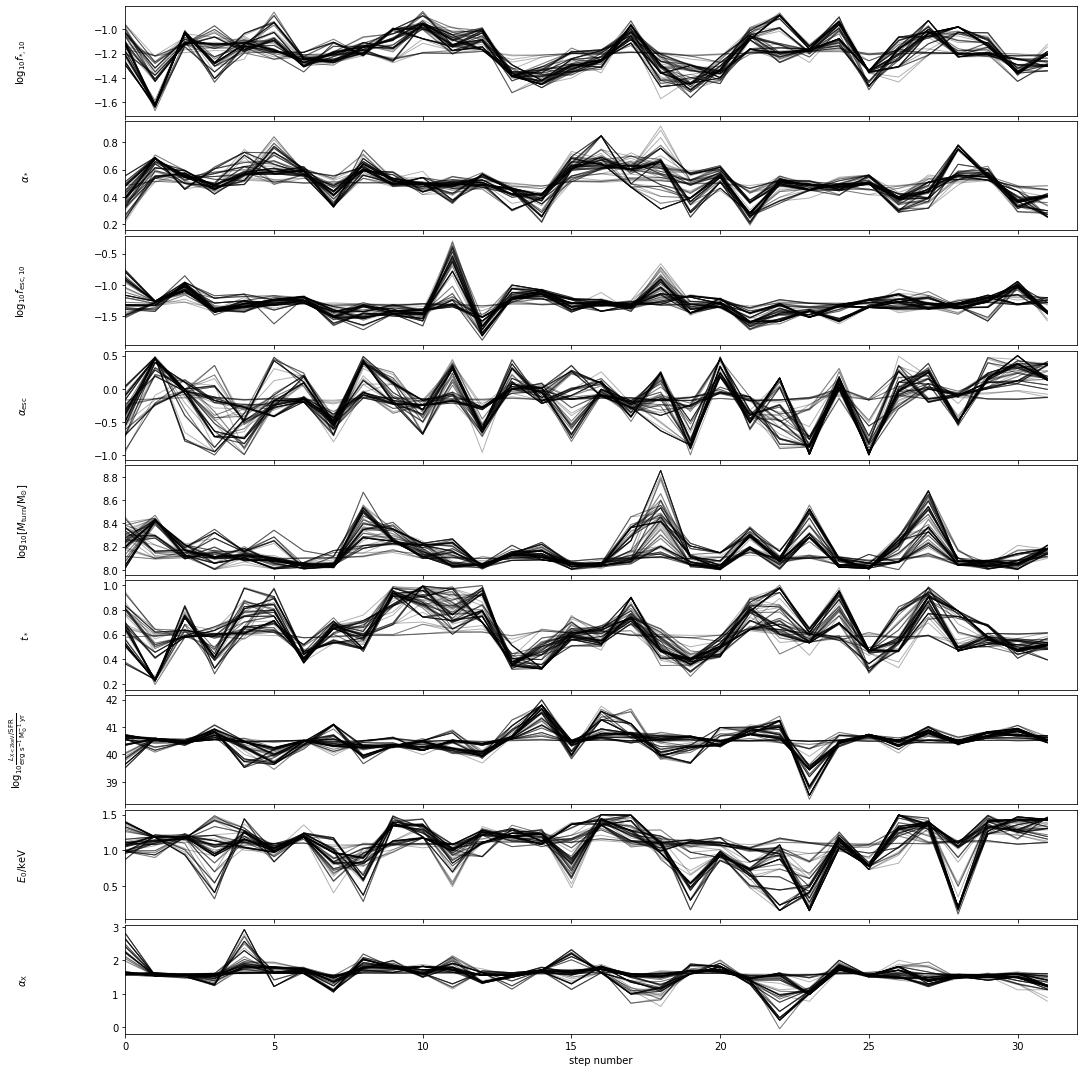

In [13]:
fig, axes = plt.subplots(len(parameters), figsize=(15, 15), sharex=True)
samples = sampler.chain
for i in range(len(parameters)):
    ax = axes[i]
    ax.plot(..., "k", alpha=0.3, lw=1)
    ax.set_xlim(...)
    ax.set_ylabel(parameters[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");
plt.tight_layout()
fig.subplots_adjust(hspace=0.05,wspace=0.05)

# let's see the new posterior

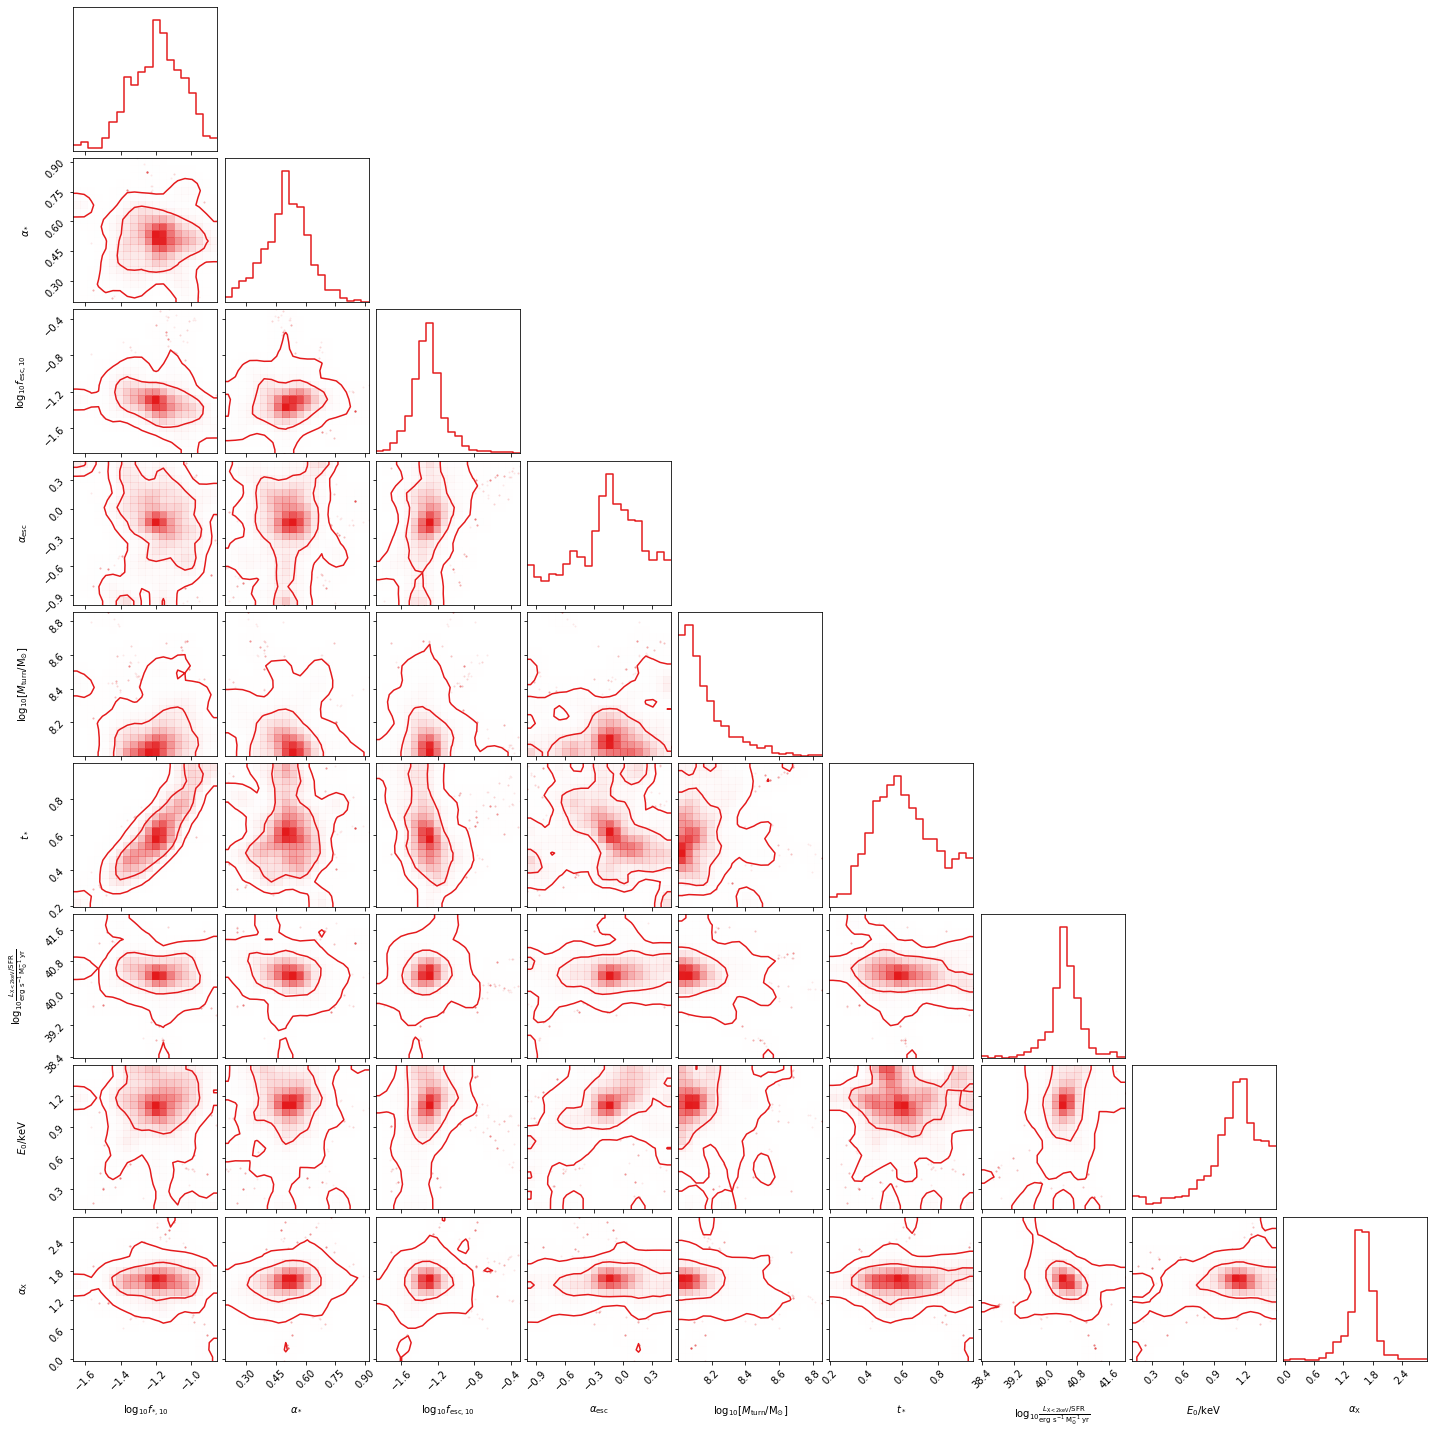

In [14]:
fig = corner.corner(...)

In [ ]:
posterior = ...
plot_data = ...

fig, axs = ...
corner.corner(...);

corner.corner(...);

### Bonus: MultiNest results

 go to the .py file